# Exercise 3
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-05-12: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')

from sklearn.linear_model import LinearRegression

# Notebook graphics settings 
%config InlineBackend.figure_format = 'svg'    # inline vector graphics
#%config InlineBackend.figure_format = 'retina' # medium resolution png:s
#plt.rcParams['figure.dpi'] = 120                # custom dpi setting png

## Task 1: Univariate AR models

In [2]:
df = pd.read_excel(r'ex3file1.xls', sheet_name='Sheet1')
df.head()

,DLPFC1,DLPFC2,Parietal1,Parietal2
0,2.28550,-0.29516,-3.0362,-4.51840
1,0.85457,-2.63380,-4.5223,-1.90250
2,-0.26151,-3.08110,-4.7146,0.47887
3,-1.19410,-2.62330,-3.9754,1.92820
4,-1.27900,-1.61420,-2.0104,3.77230


(360,)


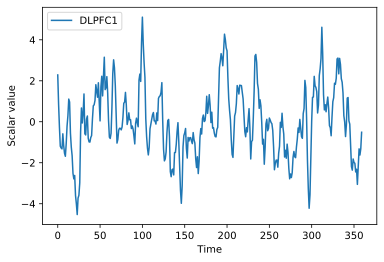

In [3]:
x1 = df['DLPFC1'].values
print(x1.shape)
plt.plot(x1, label='DLPFC1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Scalar value')
plt.show()

In [4]:
def AR_fit(x, p):
    """
    Estimate the parameters of an Auto-regressive (AR) model 
    of order p on a scalar time series x.
    
    Parameters:
    -----------
    x: np.array shape=(T,)
        Scalar valued time series.
    p: int
        Order of the AR process.

    Returns:
    --------
    coef: np.array shape=(p,)
        Coefficient estimates of the AR(p) model.
    """
    T = len(x)
    y = x[p:] # target vector

    # Regressor matrix
    X = np.zeros((T-p, p+1))    # pre-allocation
    X[:,0] = 1                  # absorbing intercept by a column of ones.
    for i in range(1, p+1):
        X[:,i] = x[p-i:T-i]     # building the regressor matrix

    # Linear regression.
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    AR_coef = reg.coef_
    # AR_coef = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # Alternative method
    return AR_coef

In [5]:
# Fitting an AR(4) model to the DLPFC1 time series.
p = 4
coef1 = AR_fit(x1, p)
print(coef1)

[-4.55062900e-04  1.24878325e+00 -4.83247551e-01  2.42845690e-01
 -1.69905103e-01]


In [6]:
def AR_predict(x, AR_coef):
    """
    One-step mean (i.e. without noise) predictions of an AR(p) model 
    on each timestep in time series x.
    """
    T = len(x)
    p = len(AR_coef)-1
    x_hat = np.zeros(T-p)
    for i, t in enumerate(range(p, T)):
        if t >= len(AR_coef):
            x_hat[i] = AR_coef[0] + AR_coef[1:].dot(x[t-1:t-len(AR_coef):-1]) 
        else:
            x_hat[i] = AR_coef[0] + AR_coef[1:].dot(x[t-1::-1])
    return x_hat

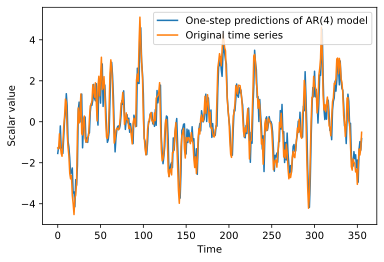

In [7]:
# One-step mean predictions of fitted AR(4) model.
x1_hat = AR_predict(x1, coef1)
plt.plot(x1_hat, label='One-step predictions of AR(4) model')
plt.plot(x1[p:], label='Original time series')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Scalar value')
plt.show()

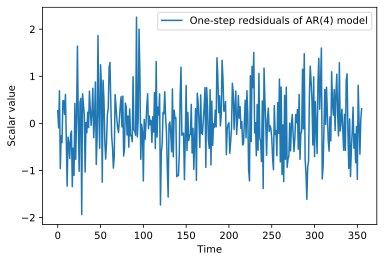

In [8]:
# AR(4) model residuals
eps = x1[p:] - x1_hat
plt.plot(eps, label='One-step redsiduals of AR(4) model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Scalar value')
plt.show()

In [9]:
# Estimating the variance of the gaussian noise term for the fitted AR(4) model.
T = len(x1)
sigma2_hat = eps.dot(eps)/(T-p) 

# Computing the log-likelihood of the fitted AR(4) model on the time series.
log_L_AR4 = -0.5*(T-p)*np.log(2*np.pi) - 0.5*(T-p)*np.log(sigma2_hat) - 0.5*eps.dot(eps)/sigma2_hat
print(log_L_AR4)

-365.7731931660897


In [10]:
max_AR_order = 5
for p in range(1, max_AR_order+1):
    coef = AR_fit(x1, p)            # fit AR(p) model
    x1_hat = AR_predict(x1, coef)   # get one-step mean predictions
    eps = x1[p:] - x1_hat           # get one-step model residuals
    sigma2_hat = eps.dot(eps)/(T-p) # estimate variance of gaussian noise
    log_L = -0.5*(T-p)*np.log(2*np.pi) - 0.5*(T-p)*np.log(sigma2_hat) - 0.5*eps.dot(eps)/sigma2_hat # compute the log-likelihood
    print(f"AR({p}) model, log-likelihood: {log_L:.5}")

AR(1) model, log-likelihood: -403.15
AR(2) model, log-likelihood: -372.82
AR(3) model, log-likelihood: -371.95
AR(4) model, log-likelihood: -365.77
AR(5) model, log-likelihood: -363.07


In [11]:
from scipy.stats import chi2

alpha = 0.05
max_AR_order = 9
T = len(x1)
for i in range(1, max_AR_order):
    p_high = i+1 
    p_low  = i 
    print(f"AR({p_low}) vs. AR({p_high}) model: ", end='')
    
    # fit AR models.
    coef_low  = AR_fit(x1, p_low)  # lower order AR model  (Null hypothesis)
    coef_high = AR_fit(x1, p_high) # higher order AR model (Alternative hypothesis)
    
    # one-step mean predictions
    x1_low_hat  = AR_predict(x1, coef_low)  
    x1_high_hat = AR_predict(x1, coef_high)
    
    # one-step model residuals
    eps_low  = x1[p_low:]  - x1_low_hat  
    eps_high = x1[p_high:] - x1_high_hat 
    
    # estimate variances of the gaussian noise terms
    sigma2_low_hat  = eps_low.dot(eps_low)/(T-p_low)    
    sigma2_high_hat = eps_high.dot(eps_high)/(T-p_high) 
    
    # compute the log-likelihoods
    log_L_low  = -0.5*(T-p_low)*np.log(2*np.pi)  - 0.5*(T-p_low)*np.log(sigma2_low_hat)   - 0.5*eps_low.dot(eps_low)/sigma2_low_hat   
    log_L_high = -0.5*(T-p_high)*np.log(2*np.pi) - 0.5*(T-p_high)*np.log(sigma2_high_hat) - 0.5*eps_high.dot(eps_high)/sigma2_high_hat
    
    D = 2*(log_L_high - log_L_low)
    #D = 2*(np.log(np.sqrt(sigma2_high_hat)) - np.log(np.sqrt(sigma2_low_hat)))
    p_value = 1 - chi2.cdf(D, 1)
    
    if p_value >= alpha:
        result = 'significant'
    else:
        result = 'not significant'
        
    print(f"p-value = {p_value:9.3}, test is {result}")

AR(1) vs. AR(2) model: p-value =  6.88e-15, test is not significant
AR(2) vs. AR(3) model: p-value =     0.185, test is significant
AR(3) vs. AR(4) model: p-value =  0.000442, test is not significant
AR(4) vs. AR(5) model: p-value =    0.0201, test is not significant
AR(5) vs. AR(6) model: p-value =  5.19e-10, test is not significant
AR(6) vs. AR(7) model: p-value =   1.9e-08, test is not significant
AR(7) vs. AR(8) model: p-value =    0.0617, test is significant
AR(8) vs. AR(9) model: p-value =    0.0629, test is significant


## Task 2: Multivariate AR (VAR) processes

(360, 4)


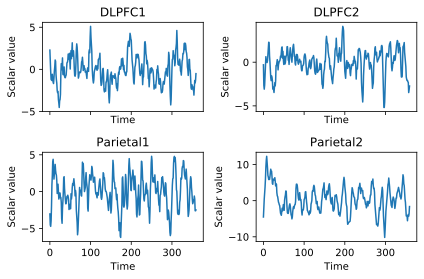

In [12]:
# Collecting the multivariate time series in a matrix.
x = df.values
print(x.shape)

# Plotting.
fig, ax = plt.subplots(2, 2, sharex=True)
ax = ax.flatten()
for i in range(4):
    ax[i].plot(x[:,i])
    ax[i].set_ylabel('Scalar value')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{df.columns.values[i]}')
fig.tight_layout()
plt.show()

In [13]:
# Fit VAR(1) model to the multivariate time series
from statsmodels.tsa.api import VAR
model = VAR(df)
results = model.fit(maxlags=1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, May, 2021
Time:                     22:41:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.53904
Nobs:                     359.000    HQIC:                  -1.66935
Log likelihood:          -1702.51    FPE:                   0.172843
AIC:                     -1.75538    Det(Omega_mle):        0.163540
--------------------------------------------------------------------
Results for equation DLPFC1
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.002490         0.039307            0.063           0.949
L1.DLPFC1            0.906687         0.028281           32.060           0.000
L1.DLPFC2           -0.020353         0.036711           -0.554

In [14]:
# Extracting coefficient matrix A.
results.params[1:]

,DLPFC1,DLPFC2,Parietal1,Parietal2
L1.DLPFC1,0.906687,0.009752,-0.012232,0.153981
L1.DLPFC2,-0.020353,0.898532,0.045263,-0.097981
L1.Parietal1,0.015690,-0.005184,0.872665,0.014444
L1.Parietal2,-0.033757,-0.007244,0.001585,0.936341


In [15]:
# Stationarity of VAR(1) process.
A = results.params[1:].values
w, v = np.linalg.eig(A)
print(f"max(abs(eig(A))) = {np.max(np.abs(w))}") 

max(abs(eig(A))) = 0.9163168597973709


## Task 3: AR Poisson process

In [16]:
# Generate a 2nd order Poisson process.
T = 1000
A1 = np.array([[0.2, -0.1], [0.1, 0.1]])
A2 = np.array([[0.1, -0.1], [0.1, 0.1]])
a0 = np.array([0, 0])
mu0 = np.array([0.5, 0.5])

In [17]:
def generate_poisson(T, A1, A2, a0, mu0):
    c = np.zeros((T, 2))
    c[0, :] = mu0
    c[1, :] = mu0
    for i in range(2, T):
        lam = np.exp(a0 + A1.dot(c[i-1]) + A2.dot(c[i-2]))
        c[i] = np.random.poisson(lam)
    return c

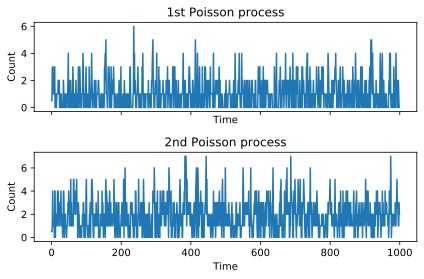

In [18]:
c = generate_poisson(T, A1, A2, a0, mu0)

# Plotting.
fig, ax = plt.subplots(2, 1, sharex=True)
ax = ax.flatten()
titles = ['1st Poisson process', '2nd Poisson process']
for i in range(2):
    ax[i].plot(c[:,i])
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{titles[i]}')
fig.tight_layout()
plt.show()

In [19]:
from scipy.special import factorial

param_range = np.arange(0, 0.4, 0.01)
log_L = np.zeros((len(param_range), len(param_range)))
for i, A1_11 in enumerate(param_range):
    for j, A2_21 in enumerate(param_range):
        A1[0, 0] = A1_11
        A2[1, 0] = A2_21
        log_lambda = a0[:, None] + A1.dot(c[p-1:-1].T) + A2.dot(c[p-2:-2].T)
        log_L[j, i] = np.sum(c[p:].T * log_lambda - np.exp(log_lambda) - np.log(factorial(c[p:]).T))

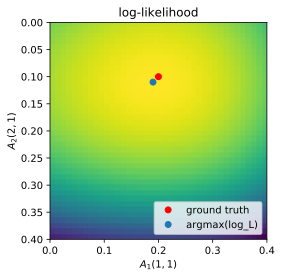

In [20]:
max_idx = np.unravel_index(log_L.argmax(), log_L.shape)
arg_max_logL = param_range[[i for i in max_idx]][::-1]

plt.imshow(log_L, extent=[0, 0.4, 0.4, 0])
plt.plot(0.2, 0.1, 'ro', label='ground truth')
plt.plot(*arg_max_logL, 'o', label='argmax(log_L)')
plt.legend(loc='lower right')
plt.xlabel('$A_1(1,1)$')
plt.ylabel('$A_2(2,1)$')
plt.title('log-likelihood')
plt.show()

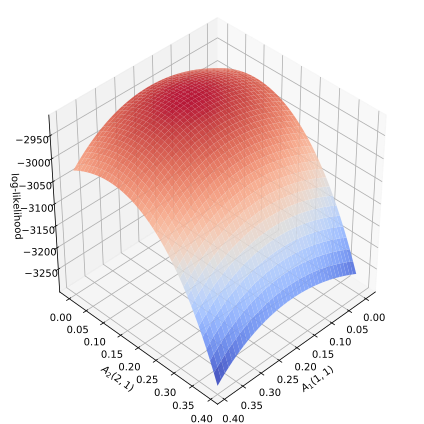

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(param_range, param_range)
surf = ax.plot_surface(X, Y, log_L, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.9)
ax.set_xlabel('$A_1(1,1)$')
ax.set_ylabel('$A_2(2,1)$')
ax.set_zlabel('log-likelihood')
ax.view_init(elev=40., azim=45)
fig.tight_layout()
plt.show()